In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import json
from sklearn.cluster import KMeans
from scipy import optimize 

In [3]:
import os

# Obtenez le chemin d'accès actuel
chemin_actuel = os.getcwd()

print("Chemin d'accès local courant :", chemin_actuel)

nouveau_chemin = '/Users/gabry/Desktop/VS/portfolio-optimization/data'

os.chdir(nouveau_chemin)

print("Nouveau chemin d'accès local :", os.getcwd())

Chemin d'accès local courant : /Users/gabry/Desktop/VS/portfolio-optimization/samples
Nouveau chemin d'accès local : /Users/gabry/Desktop/VS/portfolio-optimization/data


In [4]:
# Charger le fichier indices_prices.csv avec la colonne de date comme index
indices_price = pd.read_csv('indices_price.csv', index_col='Date', parse_dates=True)

# Charger le fichier stocks_price.csv avec la colonne de date comme index
stocks_price = pd.read_csv('stocks_price.csv', index_col='Date', parse_dates=True)

# Afficher les premières lignes pour vérifier
print(indices_price.head())
print(stocks_price.head())

                  BND        EEM          ^DJI        ^FCHI        ^FTSE  \
Date                                                                       
2022-12-02  71.258614  38.643650  34429.878906  6742.250000  7556.200195   
2022-12-05  70.696289  38.203850  33947.101562  6696.959961  7567.500000   
2022-12-06  70.928986  38.154984  33596.339844  6687.790039  7521.399902   
2022-12-07  71.549461  37.930199  33597.921875  6660.589844  7489.200195   
2022-12-08  71.345840  38.389542  33781.480469  6647.310059  7472.200195   

                  ^GDAXI        ^GSPC          ^HSI         ^IXIC  \
Date                                                                
2022-12-02  14529.389648  4071.699951  18675.349609  11461.500000   
2022-12-05  14447.610352  3998.840088  19518.289062  11239.940430   
2022-12-06  14343.190430  3941.260010  19441.179688  11014.889648   
2022-12-07  14261.190430  3933.919922  18814.820312  10958.549805   
2022-12-08  14264.559570  3963.510010  19450.230469  

In [13]:
def StockReturnsComputing(StockPrice):
    import numpy as np

    # Convertir le DataFrame Pandas en un array NumPy
    StockPriceArray = StockPrice.values

    # Récupérer le nombre de lignes et de colonnes
    Rows, Columns = StockPriceArray.shape

    # Initialiser le tableau de rendements
    StockReturn = np.zeros([Rows-1, Columns])

    # Calculer les rendements
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i, j] = ((StockPriceArray[i+1, j] - StockPriceArray[i, j]) / StockPriceArray[i, j]) * 100

    return StockReturn

# Appel de la fonction avec le DataFrame stocks_price
ret = StockReturnsComputing(stocks_price)

## Give the same results than pct_change


In [7]:
indices_daily_return = indices_price.pct_change(1) # 1 for ONE DAY lookback
indices_monthly_return = indices_price.pct_change(21) # 21 for ONE MONTH lookback
indices_annual_return = indices_price.pct_change(252) # 252 for ONE YEAR lookback

stocks_daily_return = stocks_price.pct_change(1) # 1 for ONE DAY lookback
stocks_monthly_return = stocks_price.pct_change(21) # 21 for ONE MONTH lookback
stocks_annual_return = stocks_price.pct_change(252) # 252 for ONE YEAR lookback

In [9]:
indices_D_ret = indices_daily_return*100
indices_D_ret = indices_D_ret.iloc[1:]
indices_M_ret = indices_monthly_return*100
indices_M_ret = indices_M_ret.iloc[1:]

stocks_D_ret = stocks_daily_return*100
stocks_D_ret = stocks_D_ret.iloc[1:]
stocks_M_ret = stocks_monthly_return*100
stocks_M_ret = stocks_M_ret.iloc[1:]

### Mean and Covariance of Returns

In [15]:
#compute mean returns and variance covariance matrix of stocks returns
stocks_meanReturns = np.mean(stocks_D_ret, axis = 0)
stocks_covReturns = np.cov(stocks_D_ret, rowvar=False)
stocks_covReturns = pd.DataFrame(stocks_covReturns, columns=stocks_D_ret.columns, index=stocks_D_ret.columns)
#compute mean returns and variance covariance matrix of indices returns
indices_meanReturns = np.mean(indices_D_ret, axis = 0)
indices_covReturns = np.cov(indices_D_ret, rowvar=False)
indices_covReturns = pd.DataFrame(indices_covReturns, columns=indices_D_ret.columns, index=indices_D_ret.columns)


In [16]:
indices_covReturns

,BND,EEM,^DJI,^FCHI,^FTSE,^GDAXI,^GSPC,^HSI,^IXIC,^N225
BND,0.216170,0.091550,0.033205,-0.000055,-0.020708,0.020924,0.064330,0.005387,0.107169,-0.000802
EEM,0.091550,0.973266,0.445865,0.470180,0.316126,0.460565,0.571755,0.633960,0.736831,0.110800
^DJI,0.033205,0.445865,0.572362,0.353342,0.248998,0.334117,0.598337,0.075837,0.661232,0.021096
^FCHI,-0.000055,0.470180,0.353342,0.873494,0.556967,0.754622,0.406624,0.278939,0.464145,0.168837
^FTSE,-0.020708,0.316126,0.248998,0.556967,0.547042,0.496611,0.250924,0.252614,0.244808,0.171077
^GDAXI,0.020924,0.460565,0.334117,0.754622,0.496611,0.772536,0.422379,0.263181,0.522501,0.188331
^GSPC,0.064330,0.571755,0.598337,0.406624,0.250924,0.422379,0.763469,0.135271,0.960737,0.057245
^HSI,0.005387,0.633960,0.075837,0.278939,0.252614,0.263181,0.135271,2.019615,0.267128,0.428178
^IXIC,0.107169,0.736831,0.661232,0.464145,0.244808,0.522501,0.960737,0.267128,1.345550,0.088150
^N225,-0.000802,0.110800,0.021096,0.168837,0.171077,0.188331,0.057245,0.428178,0.088150,0.978335


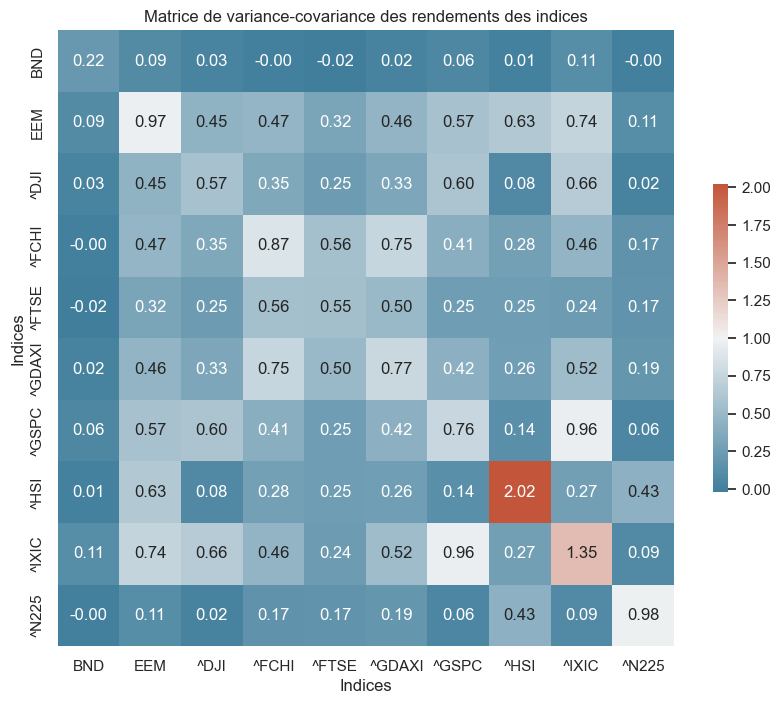

In [17]:
# Utilisons Seaborn pour une visualisation élégante.
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que 'indices_covReturns' est votre matrice de covariance réelle
# Remplacez 'dummy_cov_matrix' par 'indices_covReturns' dans votre code

# Création de la heatmap de la matrice de covariance
sns.set(style="white")

# Définir une palette de couleurs avec un contraste élevé
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Création de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(indices_covReturns, annot=True, fmt='.2f', cmap=cmap, square=True, cbar_kws={"shrink": .5})

# Ajouter des titres pour la clarté
plt.title('Matrice de variance-covariance des rendements des indices')
plt.xlabel('Indices')
plt.ylabel('Indices')

# Afficher la heatmap
plt.show()


### Beta

In [18]:
# Supposons que stocks_D_ret est votre DataFrame avec les rendements des actions
# et indices_D_ret est votre DataFrame avec les rendements des indices

# Extraire les rendements de l'indice ^IXIC
ixic_returns = indices_D_ret['^IXIC']

# Calculer la variance des rendements de l'indice ^IXIC
ixic_var = np.var(ixic_returns, ddof=1)

# Initialiser la liste pour stocker les bêtas
betas = []

# Calculer le bêta pour chaque stock
for stock in stocks_D_ret.columns:
    # Calculer la covariance entre les rendements du stock et ceux de l'indice ^IXIC
    covar = np.cov(stocks_D_ret[stock], ixic_returns, ddof=1)[0][1]
    
    # Calculer le bêta et l'ajouter à la liste
    beta = covar / ixic_var
    betas.append(beta)

# Créer une série Pandas pour les bêtas avec les noms des stocks comme index
betas_series = pd.Series(betas, index=stocks_D_ret.columns)

# Afficher les bêtas des actifs
print('Asset Betas:')
print(betas_series)


Asset Betas:
AAPL    0.937872
ABBV    0.009882
ABT     0.388923
ACN     0.863874
ADBE    1.296477
          ...   
UPS     0.752005
V       0.520814
VZ      0.224182
WMT     0.251460
XOM     0.204789
Length: 107, dtype: float64


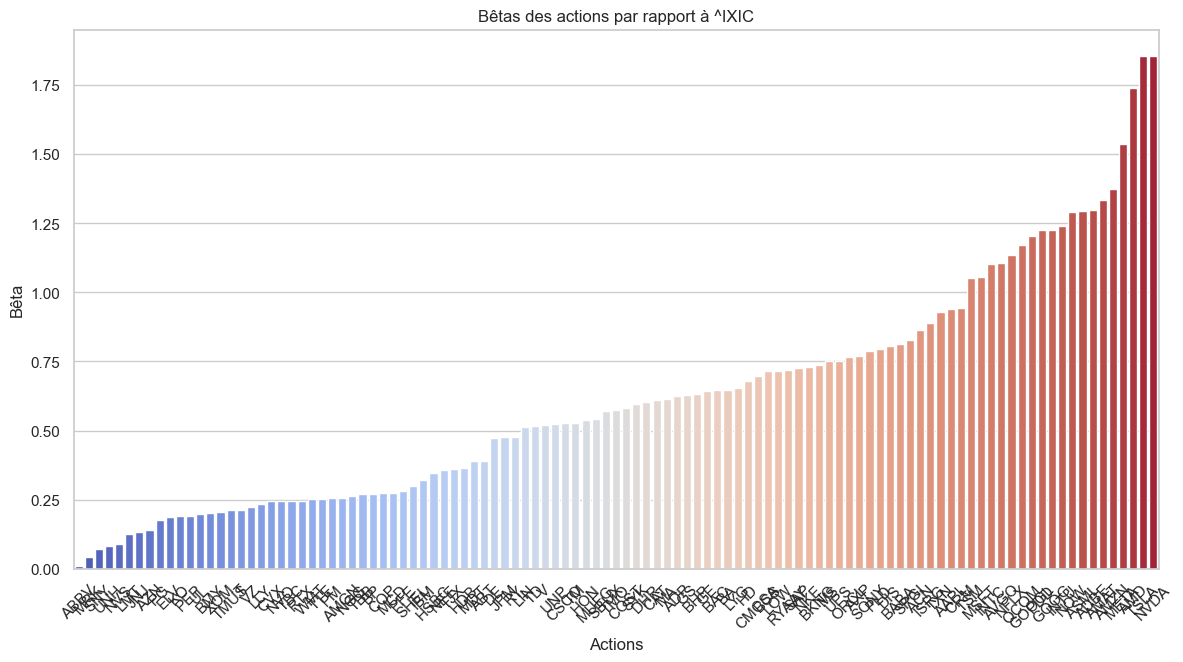

In [19]:
# Supposons que 'betas' est une liste ou une série Pandas contenant les bêtas calculés de vos actions.

# Importons d'abord les bibliothèques nécessaires.
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que 'betas_series' est la série Pandas contenant vos bêtas.
# Remplacez 'betas_series' par la série réelle contenant les bêtas de vos actions.
betas_series = pd.Series(betas_series.values, index = betas_series.index)  # Exemple de données

# Tri des bêtas pour améliorer la visualisation
betas_series_sorted = betas_series.sort_values()

# Configuration de Seaborn pour les graphiques plus esthétiques
sns.set(style="whitegrid")

# Création du graphique à barres
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=betas_series_sorted.index, y=betas_series_sorted.values, palette="coolwarm")

# Ajout de titres et d'étiquettes
plt.title('Bêtas des actions par rapport à ^IXIC')
plt.xlabel('Actions')
plt.ylabel('Bêta')

# Rotation des étiquettes des axes x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Afficher le graphique
plt.show()


### k-means Clustering

Prepare parameters for k-means clustering



In [20]:
# Convertir la série Pandas en un array NumPy
stocks_meanReturns_array = stocks_meanReturns.values

# Redimensionner l'array pour avoir une seule colonne
stocks_meanReturns_reshaped = stocks_meanReturns_array.reshape(len(stocks_meanReturns_array), 1)

assetParameters = np.concatenate([stocks_meanReturns_reshaped, stocks_covReturns], axis = 1)
print('Size of the asset parameters for clustering:\n', assetParameters.shape)
print('Asset parameters for clustering:\n', assetParameters)

Size of the asset parameters for clustering:
 (107, 108)
Asset parameters for clustering:
 [[ 1.14720551e-01  1.88434991e+00  2.56536922e-02 ...  2.74838068e-01
   3.00406203e-01  3.90853307e-01]
 [-2.93422336e-02  2.56536922e-02  1.52102417e+00 ...  1.40403273e-01
   3.21677698e-01  3.04064106e-01]
 [ 4.09575438e-03  5.21780623e-01  3.75013930e-01 ...  4.39161764e-01
   1.95277146e-01  3.63107542e-01]
 ...
 [ 4.31810479e-02  2.74838068e-01  1.40403273e-01 ...  2.15070342e+00
   3.04277081e-01  3.73167888e-01]
 [ 1.40672026e-02  3.00406203e-01  3.21677698e-01 ...  3.04277081e-01
   1.00359799e+00  3.38280760e-01]
 [ 4.28276618e-04  3.90853307e-01  3.04064106e-01 ...  3.73167888e-01
   3.38280760e-01  2.57822851e+00]]


In [21]:
#kmeans clustering of assets using the characteristic vector of 
#mean return and variance-covariance vector of returns
clusters = 7
assetLabels = stocks_D_ret.columns.tolist()
assetsCluster= KMeans(algorithm='auto',  max_iter=600, n_clusters=clusters)
print('Clustering of assets completed!') 
assetsCluster.fit(assetParameters)
centroids = assetsCluster.cluster_centers_
labels = assetsCluster.labels_

print('Centroids:\n', centroids)
print('Labels:\n', labels)

Clustering of assets completed!
Centroids:
 [[ 3.78907630e-02  3.80734575e-01  2.47031956e-01  3.03020624e-01
   4.07905226e-01  4.31217543e-01  4.79899613e-01  3.48084182e-01
   1.95021400e-01  2.60911074e-01  1.20822494e-01  4.48233512e-01
   4.63636960e-01  7.45183752e-01  2.74308391e-01  7.69758506e-01
   7.04868326e-01  1.03366818e+00  1.36098968e+00  1.06416112e+00
   5.55205094e-01  2.38669605e-01  1.78641063e+00  1.11501937e+00
   4.33519030e-01  2.18610194e+00  2.45376901e-01  3.66418281e-01
   4.62203489e-01  1.60922578e+00  7.51742501e-01  4.21648038e-01
   6.48088996e-01  4.66682276e-01  5.08896039e-01  1.69251296e-01
   1.60043576e-01  7.88596497e-01  4.13703173e-01  4.63300341e-01
   6.51370745e-01  8.26364474e-01  3.33701331e-01  3.32297481e-01
   4.87942786e-01  3.21173316e-01  1.82379324e-01  8.08219279e-01
   2.12524835e-01  5.64260921e-01  1.63670042e-01  5.46358375e-01
   4.19749681e-01  1.18816376e+00  4.74291273e-01  2.70134847e-01
   3.18382871e-01  7.79944605e-0

/Users/gabry/opt/anaconda3/envs/freqtrade_V1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gabry/opt/anaconda3/envs/freqtrade_V1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [22]:
#fixing asset labels to cluster points
print('Stocks in each of the clusters:\n',)
assets = np.array(assetLabels)
for i in range(clusters):
    print('Cluster', i+1)
    clt  = np.where(labels == i)
    assetsCluster = assets[clt]
    print(assetsCluster)

Stocks in each of the clusters:

Cluster 1
['BP' 'COP' 'CVX' 'HSBC' 'SHEL' 'TTE' 'XOM']
Cluster 2
['ADBE' 'AMAT' 'AMZN' 'ASML' 'AVGO' 'CRM' 'GOOG' 'GOOGL' 'INTC' 'INTU'
 'META' 'MSFT' 'NFLX' 'NOW' 'QCOM' 'TSM' 'TXN']
Cluster 3
['AAPL' 'ACN' 'ADP' 'BKNG' 'CMCSA' 'COST' 'CSCO' 'DHR' 'GE' 'HD' 'HON'
 'ISRG' 'LIN' 'LOW' 'MA' 'NKE' 'ORCL' 'PLD' 'SAP' 'SBUX' 'SONY' 'SPGI'
 'SYK' 'TM' 'TMO' 'UNP' 'UPS' 'V']
Cluster 4
['AXP' 'BA' 'BABA' 'BAC' 'BCS' 'BHP' 'CAT' 'DE' 'DIS' 'GS' 'JPM' 'LYG'
 'MS' 'MUFG' 'RY' 'RYAAY' 'TD']
Cluster 5
['AMD' 'NVDA' 'TSLA']
Cluster 6
['ABBV' 'ABT' 'AMGN' 'AZN' 'BMY' 'ELV' 'HDB' 'IBM' 'JNJ' 'KO' 'LLY' 'LMT'
 'MCD' 'MDT' 'MRK' 'NEE' 'NGG' 'NVO' 'NVS' 'PEP' 'PFE' 'PG' 'PM' 'RTX'
 'SNY' 'T' 'TBB' 'TBC' 'TJX' 'TMUS' 'UL' 'UNH' 'VZ' 'WMT']
Cluster 7
['PDD']


An inverse volatility weighted portfolio is one in which highly volatile assets are allotted smaller weights and low volatile assets are allotted larger weights. Thus, the weights of the individual assets in the portfolio are proportional to the reciprocals of their individual volatilities.


### Mean-Variance Optimization Model

In [25]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [26]:
#function obtains minimal risk portfolio 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])
    
    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return opt

In [27]:
#function obtains Minimal risk and Maximum return portfolios

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
    return  opt

In [29]:
portfolioSize = 107

In [30]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(stocks_meanReturns, 107)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(stocks_meanReturns.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )

/var/folders/h6/klk8j6xx0kv9dm0bgqn6tkmm0000gn/T/ipykernel_996/3754697686.py:11: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')


Maximal Expected Portfolio Return:    0.4569


In [31]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(stocks_covReturns, portfolioSize)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(stocks_meanReturns.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:   0.0093


In [32]:
# compute efficient set for the maximum return and minimum risk portfolios
increment = 0.001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

# initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(stocks_meanReturns, stocks_covReturns, portfolioSize, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment

#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251 
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,stocks_covReturns)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*251) 

#obtain expected portfolio annualized return for the
#efficient set portfolios, for trading days = 251
retPoint = 251*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape)
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

/Users/gabry/opt/anaconda3/envs/freqtrade_V1/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/gabry/opt/anaconda3/envs/freqtrade_V1/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/gabry/opt/anaconda3/envs/freqtrade_V1/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is line

Size of the  efficient set: (448, 107)
Optimal weights of the efficient set portfolios: 
 [[ 0.00745919  0.02455079  0.00886128 ...  0.00961066  0.02373255
   0.00865389]
 [ 0.00746022  0.02457176  0.00885449 ...  0.00961326  0.02376159
   0.00865247]
 [ 0.00746141  0.02459142  0.00884738 ...  0.00961588  0.02378987
   0.00865102]
 ...
 [-0.00034495 -0.00050786 -0.0004801  ... -0.00042741 -0.00046616
  -0.00047957]
 [-0.00036974 -0.00052834 -0.00050113 ... -0.00044996 -0.00048767
  -0.00050072]
 [-0.00040155 -0.00054815 -0.00052271 ... -0.00047572 -0.00051051
  -0.00052251]]
Annualized Risk and Return of the efficient set portfolios: 
 [[ 11.21615951   2.33584981]
 [ 11.2162027    2.58684981]
 [ 11.21630756   2.83784981]
 [ 11.21647882   3.08884981]
 [ 11.21672059   3.33984981]
 [ 11.21703718   3.59084981]
 [ 11.21743379   3.84184981]
 [ 11.2179157    4.09284981]
 [ 11.21848803   4.34384981]
 [ 11.21915632   4.59484981]
 [ 11.21992612   4.84584981]
 [ 11.22080329   5.09684981]
 [ 11.22

In [51]:
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint][250])

Optimal weights of the efficient set portfolios: 
 [[ 0.00745919  0.02455079  0.00886128 ...  0.00961066  0.02373255
   0.00865389]
 [ 0.00746022  0.02457176  0.00885449 ...  0.00961326  0.02376159
   0.00865247]
 [ 0.00746141  0.02459142  0.00884738 ...  0.00961588  0.02378987
   0.00865102]
 ...
 [-0.00034495 -0.00050786 -0.0004801  ... -0.00042741 -0.00046616
  -0.00047957]
 [-0.00036974 -0.00052834 -0.00050113 ... -0.00044996 -0.00048767
  -0.00050072]
 [-0.00040155 -0.00054815 -0.00052271 ... -0.00047572 -0.00051051
  -0.00052251]]
Annualized Risk and Return of the efficient set portfolios: 
 [18.95436179 65.08584981]


In [48]:
xOptimalArray[40]

array([0.00767982, 0.02306214, 0.00821605, 0.00711628, 0.00727571,
       0.00675   , 0.00657024, 0.00615358, 0.0086648 , 0.00714702,
       0.00581615, 0.00801885, 0.00688264, 0.00926776, 0.00718783,
       0.00576033, 0.0061126 , 0.00607296, 0.00650791, 0.00840777,
       0.00728364, 0.00863895, 0.00697721, 0.00791916, 0.00692577,
       0.00903836, 0.00850344, 0.00782788, 0.00715855, 0.00646663,
       0.00706738, 0.00627411, 0.00790422, 0.01138617, 0.00718878,
       0.00725945, 0.00648814, 0.00706526, 0.01024383, 0.00682335,
       0.02124587, 0.0164469 , 0.00747238, 0.00672324, 0.00707018,
       0.010913  , 0.00848629, 0.01296984, 0.00912873, 0.01216625,
       0.02593578, 0.00673506, 0.00647056, 0.00787888, 0.0106916 ,
       0.00968097, 0.00918189, 0.00933678, 0.00609017, 0.00819084,
       0.00924387, 0.00639139, 0.00740109, 0.00938642, 0.00681931,
       0.00718078, 0.00756196, 0.01477631, 0.01070819, 0.00819862,
       0.00685958, 0.0128352 , 0.00654846, 0.01575535, 0.00653

In [46]:
import plotly.graph_objects as go

# Supposons que vous voulez tracer la première ligne de xOptimalArray
ligne_a_tracer = xOptimalArray[40]

# Créer un graphique en barres
fig = go.Figure(data=[go.Bar(
            x=list(range(len(ligne_a_tracer))), 
            y=ligne_a_tracer,
            hovertext=[f'Position: {i}' for i in range(len(ligne_a_tracer))],
            hoverinfo="text+y"
)])

# Mise à jour des étiquettes et du titre
fig.update_layout(title='Bar Plot des Poids Optimaux du Portefeuille',
                  xaxis_title='Indices des Actifs',
                  yaxis_title='Poids dans le Portefeuille')

# Afficher le graphique
fig.show()


In [53]:
# Accéder au nom de la 55ème colonne
nom_colonne = stocks_price.columns[70]

print("Le nom de la 55ème colonne est :", nom_colonne)


Le nom de la 55ème colonne est : PDD


In [153]:
# Array donné
array = xOptimalArray[300]

# Valeur à rechercher
valeur_recherchee = 0.29332464

# Trouver la position de la valeur
# Utilisation d'une petite tolérance pour les nombres flottants
tolerance = 1e-8
positions = np.where(np.abs(array - valeur_recherchee) < tolerance)[0]

# Afficher les positions
print("Position(s) de", valeur_recherchee, "dans l'array:", positions)


Position(s) de 0.29332464 dans l'array: [56]


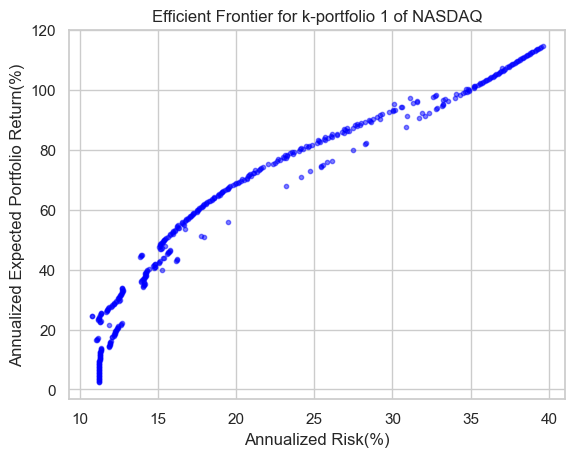

In [147]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for k-portfolio 1 of NASDAQ')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Draft

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Supposons que 'data' est un DataFrame où chaque colonne représente un stock et chaque ligne un retour quotidien

# Étape 1: Sélection aléatoire de portefeuilles
np.random.seed(0)  # Pour la reproductibilité
nombre_portefeuilles = 10  # Nombre de portefeuilles à générer
taille_portefeuille = 30   # Nombre d'actions par portefeuille

portefeuilles = []
for _ in range(nombre_portefeuilles):
    actions_choisies = np.random.choice(data.columns, taille_portefeuille, replace=False)
    portefeuilles.append(data[actions_choisies])

# Étape 2: Calcul de la frontière efficiente pour chaque portefeuille
def frontiere_efficiente(portefeuille):
    # Calculs des rendements moyens et de la matrice de covariance
    rendements_moyens = portefeuille.mean()
    covar = portefeuille.cov()
    
    # Fonction objectif (minimisation de la variance)
    def objective(weights): 
        return weights.T @ covar @ weights

    # Contraintes
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # La somme des poids = 1
    bounds = tuple((0, 1) for _ in range(len(portefeuille.columns)))  # Poids entre 0 et 1
    
    # Optimisation
    result = minimize(objective, np.array([1/len(portefeuille.columns)]*len(portefeuille.columns)), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.fun  # Retourne la variance minimale (risque)

variances = [frontiere_efficiente(portef) for portef in portefeuilles]

# Étape 3: Sélection de la meilleure frontière efficiente
meilleure_frontiere = portefeuilles[np.argmin(variances)]  # Sélection du portefeuille avec la variance la plus basse
